## Предсказание уровней воды на реке Амур

In [7]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from datetime import datetime, timedelta
from sklearn.model_selection impor!unzip -q datasets.zip;rm -rf __MACOSXt GridSearchCV

In [16]:
!unzip -q datasets.zip;rm -rf __MACOSX

In [17]:
# Путь до папки с данными
path_to_data = 'datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [18]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [19]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [22]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

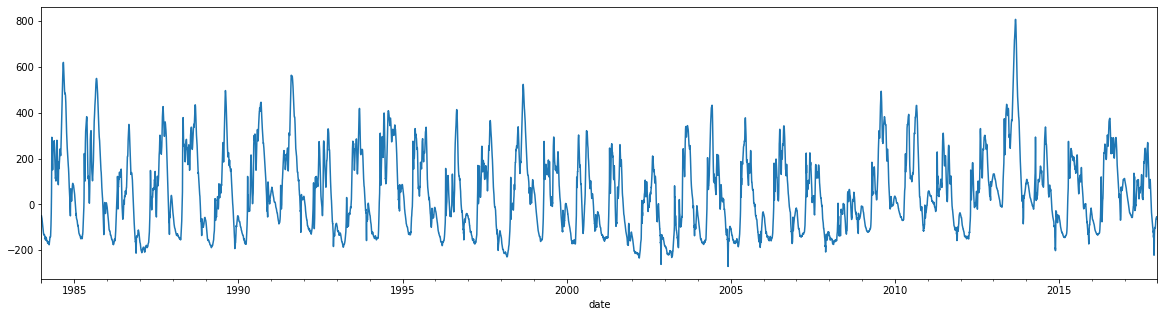

In [23]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [24]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [25]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

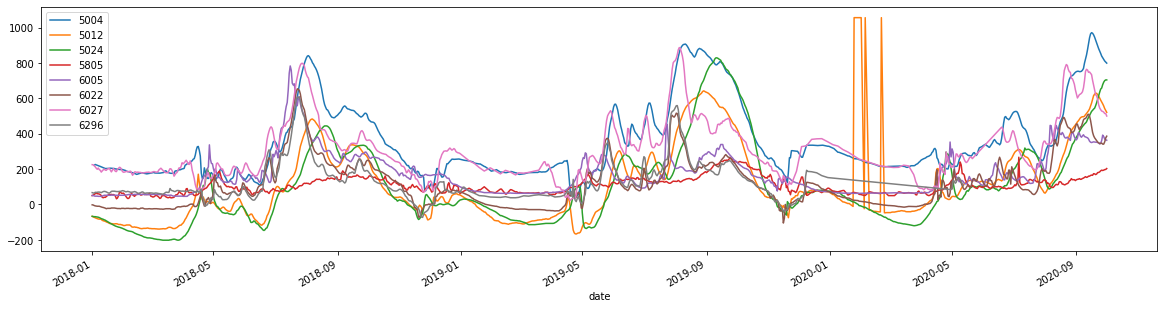

In [26]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [27]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

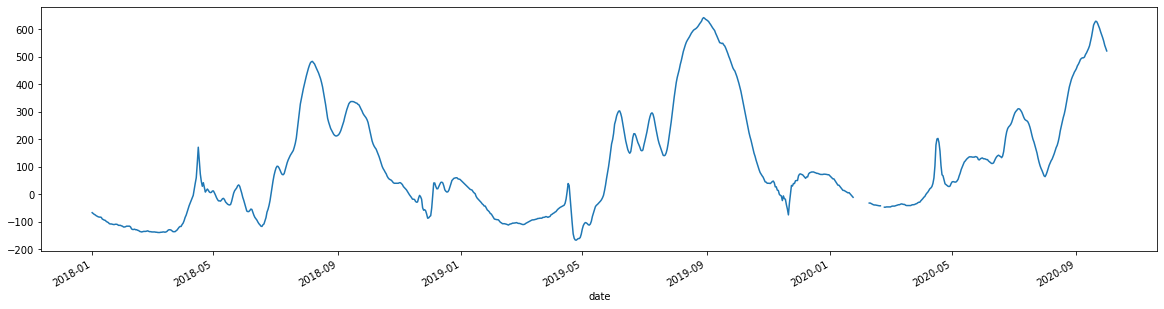

In [28]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [29]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [30]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [31]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,0,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,0,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [32]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [33]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [34]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [35]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

In [36]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [37]:
dmeteo.head()

day_temperature_air  ...  night_temperature_ground
station_id date                             ...                          
5004       1985-01-01              -17.900  ...                   -27.275
           1985-01-02              -16.775  ...                   -29.375
           1985-01-03              -18.975  ...                   -26.900
           1985-01-04              -19.150  ...                   -28.175
           1985-01-05              -21.200  ...                   -28.175

[5 rows x 4 columns]

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [38]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [39]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [40]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [41]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [42]:
daily.shape

(93596, 13)

Создаем "календарные" признаки

In [43]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [44]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [45]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [46]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [47]:
ndays = 20

In [48]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby(daily.index)['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [49]:
daily = daily[daily['target'].notna()]

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predictperiod_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [50]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [51]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [52]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [53]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью 
*train_test_fold(df, f_day, l_day)*. В качестве ошибки на валидационной выборке будем использовать метрику $MAE$

In [54]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='wmae2', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    wmae2_list = []
    for i in range(5):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'wmae2':
            eval_metr = lambda x, y: ['wmae2', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae2_list], 
                        index=['MAE', 'RMSE', 'WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 6)])
    return res_table

Посмотрим на степень влияния дополнительных признаков на результат работы модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение lightboost с дефолтными параметрами и всеми доп. признакими.

In [55]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = lgb.LGBMRegressor(random_state=33)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

In [57]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,past_1_1,past_1_2,past_1_3,past_1_4,past_1_5,past_1_6,past_1_7,past_1_8,past_1_9,past_1_10,past_2_0,past_2_1,past_2_2,past_2_3,past_2_4,past_2_5,past_2_6,past_2_7,past_2_8,past_2_9,past_2_10,past_3_0,past_3_1,past_3_2,past_3_3,past_3_4,past_3_5,past_3_6,past_3_7,past_3_8,past_3_9,past_3_10,past_4_0,past_4_1,past_4_2,past_4_3,past_4_4,past_4_5,past_4_6,past_4_7,past_4_8,past_4_9,past_4_10,past_5_0,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,300.0,40.0,40.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,-41.0,-48.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,56.0,47.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,-13.0,-18.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-62.0,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,301.0,40.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,-48.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,47.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,-18.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,302.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,16.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,-99.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,5.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-80.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0
2019-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,303.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,16.0,10.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,-99.0,-102.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,5.0,-9.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-80.0,-75.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0,-93.0


Построения графика важности дополнительных признаков.

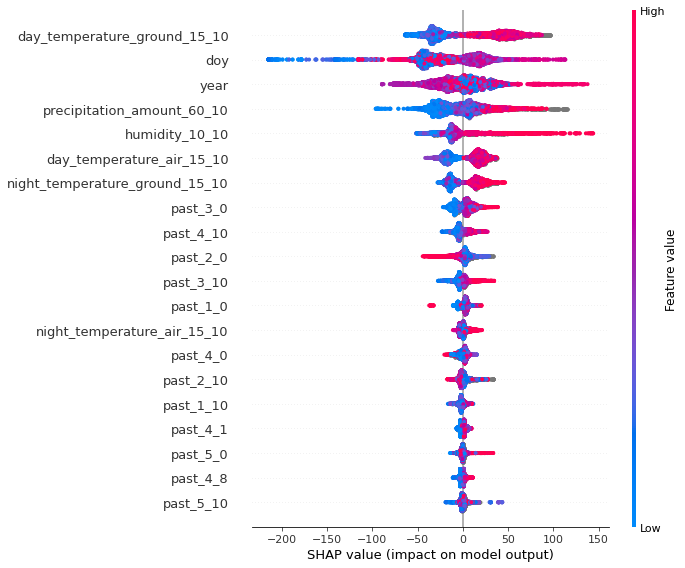

In [58]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [59]:
predict_lgb = model_lgb.predict(X_test)
true = y_test.values
metrics(true, predict_lgb, station_id)

32.75925779577402

Обучение на xgboost

In [60]:
import xgboost

In [61]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_xgb = xgboost.XGBRegressor(random_state=42)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_xgb.fit(X_train, y_train)

[19:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [62]:
predict_xgb = model_xgb.predict(X_test)
true = y_test.values
metrics(true, predict_xgb, station_id)

44.33317947387695

In [64]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 66.3MB 58kB/s 


In [65]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_cat = CatBoostRegressor(random_state=42)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_cat.fit(X_train, y_train)

Learning rate set to 0.061671
0:	learn: 167.2367705	total: 73.6ms	remaining: 1m 13s
1:	learn: 161.6279262	total: 95.1ms	remaining: 47.5s
2:	learn: 155.9891557	total: 117ms	remaining: 38.7s
3:	learn: 150.9814186	total: 138ms	remaining: 34.3s
4:	learn: 146.3728107	total: 158ms	remaining: 31.5s
5:	learn: 142.0941516	total: 180ms	remaining: 29.8s
6:	learn: 138.3950247	total: 203ms	remaining: 28.8s
7:	learn: 134.8191996	total: 225ms	remaining: 27.9s
8:	learn: 131.3314098	total: 246ms	remaining: 27.1s
9:	learn: 128.3071804	total: 268ms	remaining: 26.5s
10:	learn: 125.5446699	total: 292ms	remaining: 26.3s
11:	learn: 122.9424206	total: 318ms	remaining: 26.2s
12:	learn: 120.4515373	total: 340ms	remaining: 25.8s
13:	learn: 118.0102735	total: 372ms	remaining: 26.2s
14:	learn: 115.4279721	total: 393ms	remaining: 25.8s
15:	learn: 113.3945111	total: 417ms	remaining: 25.6s
16:	learn: 111.3996323	total: 440ms	remaining: 25.4s
17:	learn: 109.7544663	total: 462ms	remaining: 25.2s
18:	learn: 107.8693408	

In [66]:
predict_cat = model_cat.predict(X_test)
true = y_test.values
metrics(true, predict_cat, station_id)

13.268151840575012

In [67]:
predict_lgb

array([65.02802698, 65.02802698, 70.5682086 , 71.40853419, 68.10498916,
       69.84541708, 69.84541708, 71.15605208, 68.24938771, 74.3585181 ])

In [68]:
predict_xgb

array([100.85459 ,  93.24529 ,  94.562294,  78.15023 ,  78.15023 ,
        76.44563 ,  71.98088 ,  71.98088 ,  71.98088 ,  71.98088 ],
      dtype=float32)

In [69]:
predict_cat

array([59.76232077, 54.80944002, 48.20776896, 44.91672919, 49.09198758,
       48.3346344 , 43.79909413, 49.37073082, 50.12292595, 50.26588658])

In [70]:
pred = (predict_lgb + predict_xgb + predict_cat) / 3

In [71]:
pred

array([75.21497971, 71.02758655, 71.11275719, 64.8251646 , 65.11573572,
       64.87522814, 61.87513065, 64.16922121, 63.4510648 , 65.53509514])

In [72]:
true = y_test.values
metrics(true, pred, station_id)

30.120196370075327

###  GridSearch для поиска параметров модели

Простая функция для поиска трех основных параметров модели обучения:

In [73]:
def grid_search_lgb(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_lgb = lgb.LGBMRegressor(n_estimators=ne,
                                              learning_rate=lr,
                                              num_leaves=nl,
                                              random_state=42)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_lgb, df, gen, 'target', features, ndays, 
                                predict_ndays, station_id, ts, 'wmae2', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, nl]))
    return best_params

In [74]:
def grid_search_xgb(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_xgb = xgboost.XGBRegressor(n_estimators=ne,
                                              learning_rate=lr,
                                              num_leaves=nl,
                                              random_state=42)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_xgb, df, gen, 'target', features, ndays, 
                                predict_ndays, station_id, ts, 'wmae2', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, nl]))
    return best_params

In [80]:
def grid_search_cat(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_cat = CatBoostRegressor(n_estimators=ne,
                                              learning_rate=lr,
                                              random_state=42)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_cat, df, gen, 'target', features, ndays, 
                                predict_ndays, station_id, ts, 'wmae2', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, nl]))
    return best_params

In [81]:
grid_params = {
    'n_estimators': [30, 70, 110],
    'learning_rate': [0.05, 0.1, 0.12],
    'num_leaves': [27, 31, 37]
}

In [82]:
model_params_cat = {}
for station_id in station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params_cat[station_id] = grid_search_cat(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

Streaming output truncated to the last 5000 lines.
20:	learn: 23.3090145	total: 474ms	remaining: 1.1s
21:	learn: 23.1246343	total: 495ms	remaining: 1.08s
22:	learn: 22.8596318	total: 517ms	remaining: 1.06s
23:	learn: 22.7070350	total: 538ms	remaining: 1.03s
24:	learn: 22.5420451	total: 560ms	remaining: 1.01s
25:	learn: 22.4182719	total: 588ms	remaining: 995ms
26:	learn: 22.1580303	total: 616ms	remaining: 981ms
27:	learn: 21.8908712	total: 643ms	remaining: 965ms
28:	learn: 21.7356833	total: 665ms	remaining: 940ms
29:	learn: 21.5047294	total: 688ms	remaining: 917ms
30:	learn: 21.4300477	total: 708ms	remaining: 891ms
31:	learn: 21.2942101	total: 729ms	remaining: 866ms
32:	learn: 21.1571693	total: 750ms	remaining: 841ms
33:	learn: 20.9424356	total: 772ms	remaining: 818ms
34:	learn: 20.7878870	total: 793ms	remaining: 793ms
35:	learn: 20.7334776	total: 814ms	remaining: 769ms
36:	learn: 20.6145409	total: 836ms	remaining: 746ms
37:	learn: 20.5014886	total: 860ms	remaining: 724ms
38:	learn: 20.

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

In [86]:
from catboost import save_model

ImportError: ignored

0:	learn: 128.2990062	total: 22.2ms	remaining: 643ms
1:	learn: 120.9409360	total: 44.3ms	remaining: 621ms
2:	learn: 114.4687595	total: 66.1ms	remaining: 595ms
3:	learn: 109.1916574	total: 87.8ms	remaining: 571ms
4:	learn: 104.4227637	total: 110ms	remaining: 548ms
5:	learn: 100.3003927	total: 137ms	remaining: 550ms
6:	learn: 96.9509815	total: 163ms	remaining: 535ms
7:	learn: 94.2829311	total: 187ms	remaining: 514ms
8:	learn: 91.7695937	total: 209ms	remaining: 489ms
9:	learn: 89.2133062	total: 234ms	remaining: 468ms
10:	learn: 87.0625682	total: 256ms	remaining: 442ms
11:	learn: 85.4647526	total: 278ms	remaining: 417ms
12:	learn: 84.0093120	total: 299ms	remaining: 392ms
13:	learn: 82.6553532	total: 322ms	remaining: 367ms
14:	learn: 81.3447506	total: 343ms	remaining: 343ms
15:	learn: 80.2749458	total: 365ms	remaining: 320ms
16:	learn: 79.1649792	total: 387ms	remaining: 296ms
17:	learn: 78.3664751	total: 409ms	remaining: 273ms
18:	learn: 77.3995168	total: 433ms	remaining: 251ms
19:	learn: 7

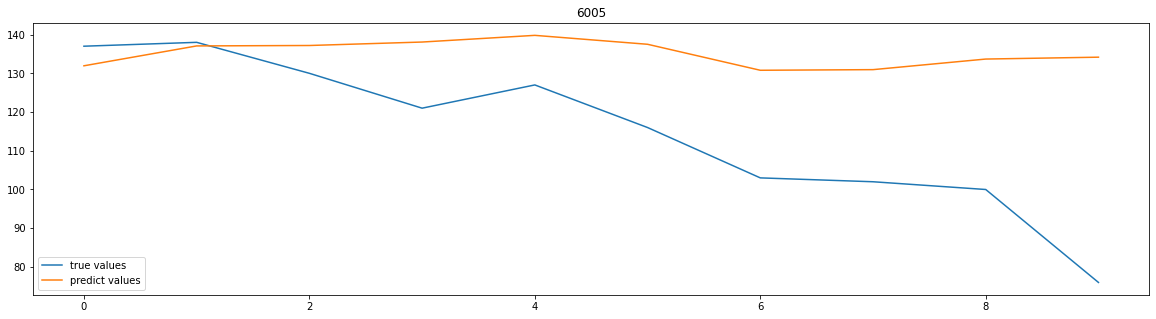

0:	learn: 126.0869041	total: 21.9ms	remaining: 2.39s
1:	learn: 118.3918942	total: 44.3ms	remaining: 2.39s
2:	learn: 112.0659462	total: 68ms	remaining: 2.42s
3:	learn: 106.7329822	total: 90.1ms	remaining: 2.39s
4:	learn: 102.2713269	total: 112ms	remaining: 2.36s
5:	learn: 98.4178497	total: 134ms	remaining: 2.32s
6:	learn: 95.0053272	total: 156ms	remaining: 2.3s
7:	learn: 92.2213220	total: 178ms	remaining: 2.26s
8:	learn: 89.8684021	total: 199ms	remaining: 2.23s
9:	learn: 88.0759767	total: 223ms	remaining: 2.23s
10:	learn: 85.8100437	total: 244ms	remaining: 2.2s
11:	learn: 84.1450357	total: 266ms	remaining: 2.17s
12:	learn: 82.6691403	total: 287ms	remaining: 2.14s
13:	learn: 81.0399609	total: 308ms	remaining: 2.11s
14:	learn: 79.7293283	total: 329ms	remaining: 2.08s
15:	learn: 78.5481666	total: 350ms	remaining: 2.05s
16:	learn: 77.5090291	total: 371ms	remaining: 2.03s
17:	learn: 76.6087082	total: 396ms	remaining: 2.03s
18:	learn: 75.8851952	total: 421ms	remaining: 2.02s
19:	learn: 75.089

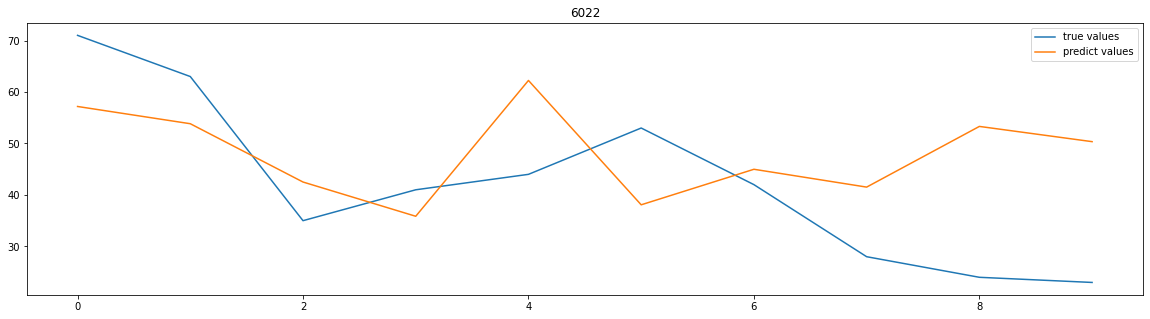

0:	learn: 153.2366092	total: 24ms	remaining: 1.66s
1:	learn: 145.2095358	total: 46.6ms	remaining: 1.58s
2:	learn: 137.9615483	total: 68.1ms	remaining: 1.52s
3:	learn: 132.1272638	total: 90.2ms	remaining: 1.49s
4:	learn: 127.0194221	total: 120ms	remaining: 1.56s
5:	learn: 122.9822304	total: 141ms	remaining: 1.51s
6:	learn: 119.1978249	total: 163ms	remaining: 1.46s
7:	learn: 115.9176419	total: 186ms	remaining: 1.44s
8:	learn: 113.1994520	total: 208ms	remaining: 1.41s
9:	learn: 110.9580980	total: 237ms	remaining: 1.42s
10:	learn: 108.6772827	total: 258ms	remaining: 1.38s
11:	learn: 106.7143634	total: 279ms	remaining: 1.35s
12:	learn: 104.8165607	total: 301ms	remaining: 1.32s
13:	learn: 103.2874348	total: 322ms	remaining: 1.29s
14:	learn: 102.1157334	total: 344ms	remaining: 1.26s
15:	learn: 100.8225366	total: 365ms	remaining: 1.23s
16:	learn: 99.8212372	total: 390ms	remaining: 1.21s
17:	learn: 98.7582813	total: 411ms	remaining: 1.19s
18:	learn: 97.7751397	total: 435ms	remaining: 1.17s
19:	

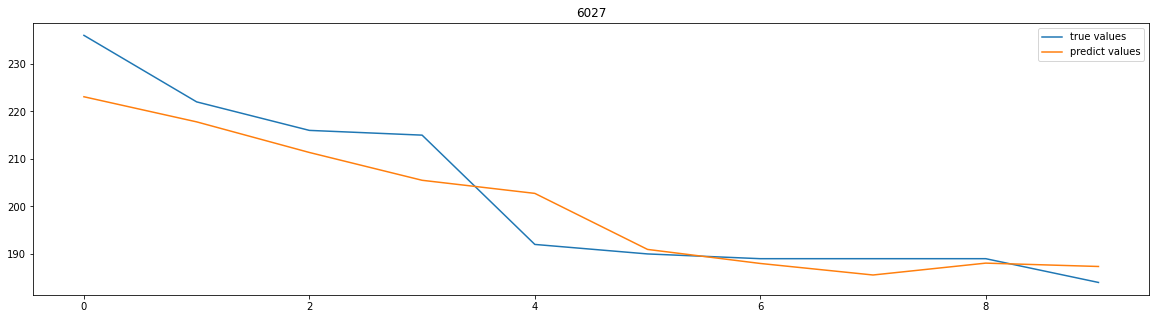

0:	learn: 176.2671109	total: 22.5ms	remaining: 2.46s
1:	learn: 167.6953269	total: 44.6ms	remaining: 2.41s
2:	learn: 159.5966616	total: 67.1ms	remaining: 2.39s
3:	learn: 152.8396630	total: 89.2ms	remaining: 2.36s
4:	learn: 146.3934752	total: 121ms	remaining: 2.54s
5:	learn: 141.1868832	total: 142ms	remaining: 2.47s
6:	learn: 136.5437449	total: 163ms	remaining: 2.4s
7:	learn: 132.6460352	total: 186ms	remaining: 2.37s
8:	learn: 129.1753053	total: 208ms	remaining: 2.33s
9:	learn: 125.6211841	total: 234ms	remaining: 2.34s
10:	learn: 122.1937780	total: 255ms	remaining: 2.3s
11:	learn: 119.0269581	total: 277ms	remaining: 2.26s
12:	learn: 116.6186268	total: 301ms	remaining: 2.24s
13:	learn: 114.6330738	total: 326ms	remaining: 2.23s
14:	learn: 112.8428676	total: 348ms	remaining: 2.21s
15:	learn: 111.1078646	total: 370ms	remaining: 2.17s
16:	learn: 109.4961185	total: 392ms	remaining: 2.14s
17:	learn: 108.1885342	total: 413ms	remaining: 2.11s
18:	learn: 106.9500425	total: 438ms	remaining: 2.1s
19

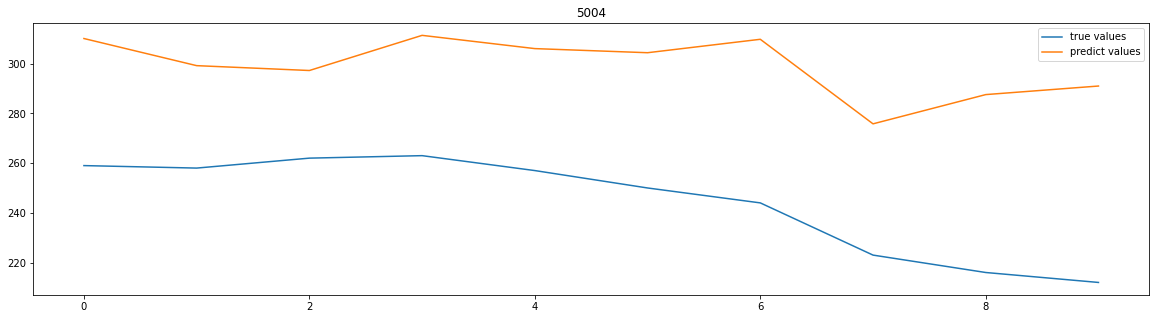

0:	learn: 161.1604420	total: 23ms	remaining: 2.51s
1:	learn: 150.7110398	total: 46.4ms	remaining: 2.5s
2:	learn: 142.1414975	total: 68.5ms	remaining: 2.44s
3:	learn: 134.7036669	total: 90.4ms	remaining: 2.39s
4:	learn: 128.4450097	total: 112ms	remaining: 2.36s
5:	learn: 123.0021488	total: 134ms	remaining: 2.33s
6:	learn: 118.4053407	total: 156ms	remaining: 2.3s
7:	learn: 114.3858505	total: 182ms	remaining: 2.32s
8:	learn: 110.7852337	total: 204ms	remaining: 2.28s
9:	learn: 107.6797458	total: 229ms	remaining: 2.29s
10:	learn: 104.7374752	total: 250ms	remaining: 2.25s
11:	learn: 102.2238886	total: 272ms	remaining: 2.22s
12:	learn: 100.1816046	total: 294ms	remaining: 2.19s
13:	learn: 97.5627951	total: 317ms	remaining: 2.17s
14:	learn: 95.7215875	total: 340ms	remaining: 2.16s
15:	learn: 93.9339125	total: 362ms	remaining: 2.13s
16:	learn: 92.6634186	total: 383ms	remaining: 2.09s
17:	learn: 91.3372309	total: 404ms	remaining: 2.07s
18:	learn: 90.2733642	total: 428ms	remaining: 2.05s
19:	learn

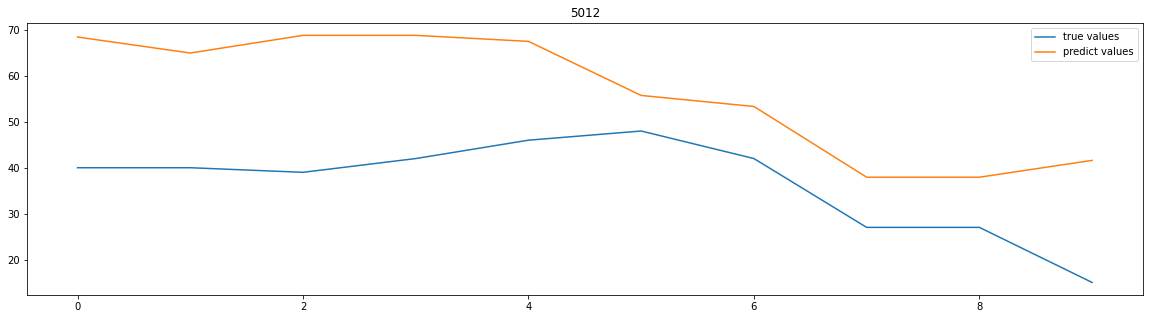

0:	learn: 190.1704292	total: 22.3ms	remaining: 646ms
1:	learn: 185.0224204	total: 43.8ms	remaining: 613ms
2:	learn: 179.9266374	total: 66.3ms	remaining: 596ms
3:	learn: 175.2406931	total: 88.4ms	remaining: 575ms
4:	learn: 171.0109362	total: 111ms	remaining: 557ms
5:	learn: 167.0161414	total: 134ms	remaining: 535ms
6:	learn: 163.2886780	total: 156ms	remaining: 511ms
7:	learn: 159.5853951	total: 178ms	remaining: 488ms
8:	learn: 156.0976655	total: 200ms	remaining: 466ms
9:	learn: 152.8757271	total: 225ms	remaining: 451ms
10:	learn: 149.3453340	total: 256ms	remaining: 442ms
11:	learn: 146.2119963	total: 280ms	remaining: 421ms
12:	learn: 143.3582266	total: 305ms	remaining: 399ms
13:	learn: 140.9460442	total: 327ms	remaining: 373ms
14:	learn: 138.3463566	total: 348ms	remaining: 348ms
15:	learn: 135.9551636	total: 371ms	remaining: 324ms
16:	learn: 133.6857556	total: 392ms	remaining: 300ms
17:	learn: 131.8322042	total: 415ms	remaining: 276ms
18:	learn: 129.9030209	total: 440ms	remaining: 255ms

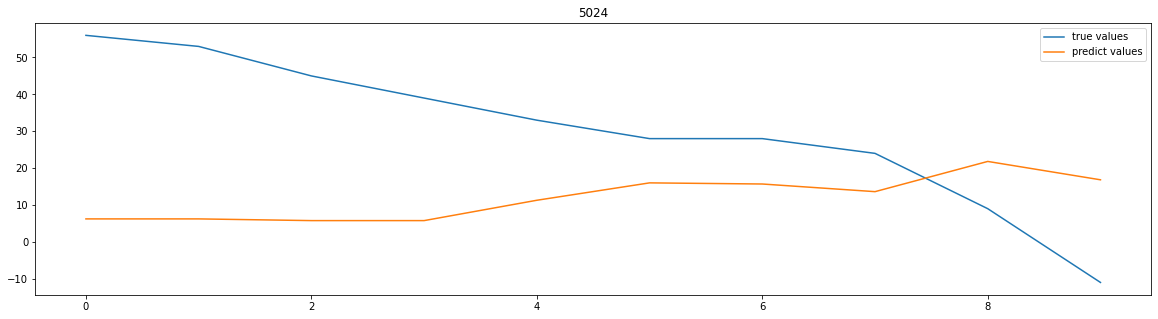

0:	learn: 40.5418057	total: 21.9ms	remaining: 2.38s
1:	learn: 38.1527562	total: 44.1ms	remaining: 2.38s
2:	learn: 36.0437575	total: 65.8ms	remaining: 2.35s
3:	learn: 34.3229306	total: 87.4ms	remaining: 2.31s
4:	learn: 32.6929905	total: 109ms	remaining: 2.28s
5:	learn: 31.2978987	total: 130ms	remaining: 2.25s
6:	learn: 30.2252769	total: 155ms	remaining: 2.29s
7:	learn: 29.2406238	total: 184ms	remaining: 2.34s
8:	learn: 28.4556100	total: 209ms	remaining: 2.35s
9:	learn: 27.8095322	total: 235ms	remaining: 2.35s
10:	learn: 27.0463573	total: 257ms	remaining: 2.31s
11:	learn: 26.5507504	total: 278ms	remaining: 2.27s
12:	learn: 26.0892146	total: 300ms	remaining: 2.24s
13:	learn: 25.5614905	total: 321ms	remaining: 2.2s
14:	learn: 25.2540895	total: 342ms	remaining: 2.17s
15:	learn: 24.9835169	total: 364ms	remaining: 2.14s
16:	learn: 24.7141112	total: 385ms	remaining: 2.11s
17:	learn: 24.4935865	total: 406ms	remaining: 2.08s
18:	learn: 24.1540631	total: 428ms	remaining: 2.05s
19:	learn: 23.85667

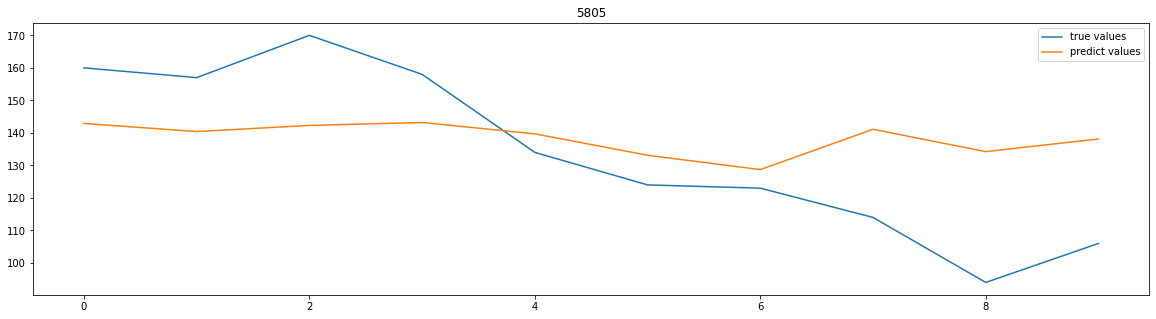

In [87]:
sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
cat_metrics = {}
for key in model_params_cat:
    station_id = int(key)
    params = model_params_cat[key]
    model_cat = CatBoostRegressor(n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              random_state=33)
    sf = daily.loc[int(key)]
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    model_cat.fit(X_train, y_train)
    model_cat.save_model(str(key))
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_cat, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    cat_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

Сформируем файл с результатом

In [84]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,131.941458,57.183308,223.078344,310.112285,68.479189,6.230805,142.912947
2019-11-02,137.072178,53.834105,217.792837,299.201379,64.995291,6.230805,140.408674
2019-11-03,137.182969,42.508449,211.351656,297.248154,68.846466,5.767957,142.301615
2019-11-04,138.076554,35.856205,205.499684,311.387277,68.846466,5.767957,143.191186
2019-11-05,139.802024,62.238025,202.742608,306.058242,67.535177,11.284895,139.706081
2019-11-06,137.497271,38.082592,190.949327,304.403482,55.751524,16.000604,133.121191
2019-11-07,130.786306,44.985051,187.994288,309.803736,53.346251,15.693358,128.710702
2019-11-08,130.948929,41.520622,185.567453,275.794945,37.932445,13.618368,141.108125
2019-11-09,133.682444,53.310170,188.065646,287.559895,37.932445,21.813324,134.238936
2019-11-10,134.166249,50.349859,187.359372,291.003576,41.600149,16.833021,138.131185


Сохранение результата

In [85]:
sample_submission.to_csv('sample_submission.csv')